In [1]:
import numpy as np
import scipy as sp
import sklearn as skl
import skimage as ski
import os
from glob import glob
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import seaborn as sns

In [18]:
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
dataset = Path("Y:/kau/диплом/data/dataset")
workdir = Path("Y:/kau/диплом/data/run-normality")

In [3]:
feature_paths = list(dataset.glob('hist_*')) + list(dataset.glob('reb_hist_*'))
feature_names = [ fp.stem for fp in feature_paths]
feature_names

['hist_R1_P8_d',
 'hist_R1_P8_u',
 'hist_R2_P12_d',
 'hist_R2_P12_u',
 'hist_R3_P24_u',
 'hist_R5_P36_u',
 'reb_hist_R1_P8_d',
 'reb_hist_R2_P12_d']

In [4]:
features = [np.load(fp) for fp in feature_paths]

In [5]:
labels = np.load(dataset / 'labels.npy')
y_set, y_tex = labels.T
unique_sets = np.unique(y_set)
unique_texs = np.unique(y_tex)
unique_sets, unique_texs

(array([1, 2, 3]), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]))

In [22]:
# First feature
X = features[0]
X_cl = np.array([ X[y_tex == k] for k in unique_texs ])
means = X_cl.mean(axis=1)

In [6]:
def check_class_differ(means, unique_classes, alpha=0.05, method='log-likelihood'):
    # for a single feature!

    # how class j is similar to class i
    n = means.shape[0] # number of classes

    class_similarity = np.zeros((n,n), dtype=np.float64)
    class_similarity_p = np.zeros((n,n), dtype=np.float64)

    for c1 in range(n): 
        for c2 in range(n):
            if c1 == c2: continue
            stat, pval = sp.stats.power_divergence(f_obs=means[c2], f_exp=means[c1], lambda_=method)
            class_similarity[c1,c2] = stat
            class_similarity_p[c1,c2] = pval
            
            if pval > alpha:
                print(f"Class {unique_classes[c2]} is too close to {unique_classes[c1]}! P={pval:.3f}, stat={stat:.2f}")

    return class_similarity, class_similarity_p

In [7]:
def f_check_class_differ(feature, classes, unique_classes, alpha=0.05, method='log-likelihood'):
    X_cl = np.array([ feature[classes == k] for k in unique_classes ])
    means = X_cl.mean(axis=1)

    S,P = check_class_differ(means, unique_classes, alpha, method)

    P1 = P > alpha
    Psym = P1 & P1.T
    nclose = (np.triu(Psym>alpha) ).sum()
    print(f"> Found {nclose} class collisions")

    return S,P

In [9]:
S0, P0 = f_check_class_differ(features[0], y_tex, unique_texs)


Class 4 is too close to 2! P=1.000, stat=131.72
Class 7 is too close to 2! P=0.133, stat=280.19
Class 2 is too close to 4! P=1.000, stat=130.90
Class 2 is too close to 7! P=0.076, stat=288.02
Class 11 is too close to 7! P=0.884, stat=228.30
Class 13 is too close to 7! P=1.000, stat=177.84
Class 7 is too close to 11! P=0.836, stat=232.87
Class 13 is too close to 11! P=0.664, stat=244.89
Class 7 is too close to 13! P=1.000, stat=177.25
Class 11 is too close to 13! P=0.730, stat=240.74
> Found 5 class collisions


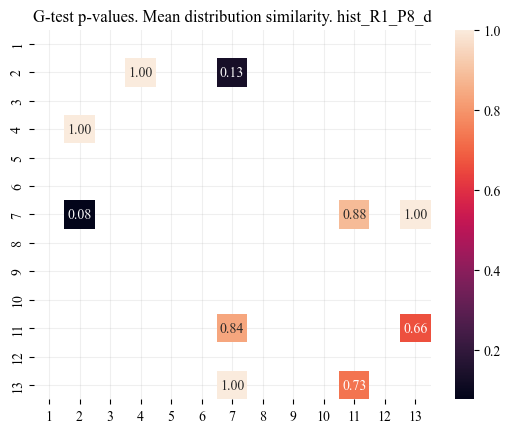

In [ ]:
sns.heatmap(P0, annot=P0, mask=(P0 < 0.05), xticklabels=unique_texs, yticklabels=unique_texs, fmt=".2f", vmin=0.05, vmax=1.0)
plt.title(f"G-test p-values. Mean distribution similarity. {feature_names[0]}")
plt.grid(alpha=0.2)
plt.gca().set_axisbelow(True)

In [29]:
print("Log-likelihood distribution similarity")

for f,fn in zip(features, feature_names):
    print("Feature ", fn, ".")
    S,P = f_check_class_differ(f, y_tex, unique_texs)
    print()

    fig = plt.figure()
    sns.heatmap(P, annot=P, mask=(P < 0.05), xticklabels=unique_texs, yticklabels=unique_texs, fmt=".2f", vmin=0.05, vmax=1.0)
    plt.title(f"G-test p-values. Mean distribution similarity. {fn}")
    plt.grid(alpha=0.2)
    plt.gca().set_axisbelow(True)
    plt.savefig(f'similarity/{fn}.png', dpi=120, bbox_inches='tight')
    plt.close(fig)

Log-likelihood distribution similarity
Feature  hist_R1_P8_d .
Class 4 is too close to 2! P=1.000, stat=131.72
Class 7 is too close to 2! P=0.133, stat=280.19
Class 2 is too close to 4! P=1.000, stat=130.90
Class 2 is too close to 7! P=0.076, stat=288.02
Class 11 is too close to 7! P=0.884, stat=228.30
Class 13 is too close to 7! P=1.000, stat=177.84
Class 7 is too close to 11! P=0.836, stat=232.87
Class 13 is too close to 11! P=0.664, stat=244.89
Class 7 is too close to 13! P=1.000, stat=177.25
Class 11 is too close to 13! P=0.730, stat=240.74
> Found 5 class collisions

Feature  hist_R1_P8_u .
> Found 0 class collisions

Feature  hist_R2_P12_d .
Class 5 is too close to 8! P=1.000, stat=3773.15
Class 6 is too close to 8! P=0.992, stat=3879.95
Class 9 is too close to 8! P=1.000, stat=1763.60
Class 12 is too close to 8! P=1.000, stat=1939.90
Class 8 is too close to 9! P=1.000, stat=1703.63
> Found 1 class collisions



y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)
y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: invalid value encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)


Feature  hist_R2_P12_u .
> Found 0 class collisions

Feature  hist_R3_P24_u .
> Found 0 class collisions

Feature  hist_R5_P36_u .
> Found 0 class collisions

Feature  reb_hist_R1_P8_d .
> Found 0 class collisions

Feature  reb_hist_R2_P12_d .
Class 4 is too close to 2! P=0.175, stat=101.36
Class 2 is too close to 4! P=0.178, stat=101.16
> Found 1 class collisions



In [30]:
unique_sets

array([1, 2, 3])

In [33]:
for s in unique_sets:
    print(f"Log-likelihood distribution similarity IN SUBSET {s}")

    for f,fn in zip(features, feature_names):
        f = f[y_set == s]
        y = y_tex[y_set == s]
        print("Feature ", fn, ".", end='')
        S,P = f_check_class_differ(f, y, unique_texs)
        # print()
        fig = plt.figure()
        sns.heatmap(P, annot=P, mask=(P < 0.05), xticklabels=unique_texs, yticklabels=unique_texs, fmt=".2f", vmin=0.05, vmax=1.0)
        plt.title(f"G-test p-values. Mean distribution similarity. {fn} [Subset {s}]")
        plt.grid(alpha=0.2)
        plt.gca().set_axisbelow(True)
        plt.savefig(f'similarity/subset{s}_{fn}.png', dpi=120, bbox_inches='tight')
        plt.close(fig)

Log-likelihood distribution similarity IN SUBSET 1
Feature  hist_R1_P8_d .> Found 0 class collisions


y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)
y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: invalid value encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)


Feature  hist_R1_P8_u .> Found 0 class collisions
Feature  hist_R2_P12_d .> Found 0 class collisions


y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)
y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: invalid value encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)


Feature  hist_R2_P12_u .> Found 0 class collisions
Feature  hist_R3_P24_u .> Found 0 class collisions
Feature  hist_R5_P36_u .> Found 0 class collisions
Feature  reb_hist_R1_P8_d .> Found 0 class collisions
Feature  reb_hist_R2_P12_d .> Found 0 class collisions
Log-likelihood distribution similarity IN SUBSET 2
Feature  hist_R1_P8_d .> Found 0 class collisions


y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)
y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: invalid value encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)


Feature  hist_R1_P8_u .> Found 0 class collisions
Feature  hist_R2_P12_d .> Found 0 class collisions


y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)
y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: invalid value encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)


Feature  hist_R2_P12_u .> Found 0 class collisions
Feature  hist_R3_P24_u .> Found 0 class collisions
Feature  hist_R5_P36_u .> Found 0 class collisions
Feature  reb_hist_R1_P8_d .> Found 0 class collisions
Feature  reb_hist_R2_P12_d .> Found 0 class collisions
Log-likelihood distribution similarity IN SUBSET 3
Feature  hist_R1_P8_d .Class 4 is too close to 2! P=1.000, stat=153.80
Class 2 is too close to 4! P=1.000, stat=154.98
Class 11 is too close to 7! P=0.656, stat=245.39
Class 13 is too close to 7! P=1.000, stat=152.98
Class 7 is too close to 11! P=0.512, stat=253.63
Class 13 is too close to 11! P=0.998, stat=195.09
Class 7 is too close to 13! P=1.000, stat=154.96
Class 11 is too close to 13! P=0.998, stat=194.84
> Found 4 class collisions
Feature  hist_R1_P8_u .> Found 0 class collisions
Feature  hist_R2_P12_d .Class 9 is too close to 8! P=0.975, stat=3919.49
Class 12 is too close to 8! P=1.000, stat=2895.84
Class 8 is too close to 9! P=1.000, stat=3233.05
Class 12 is too close t

y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)
y:\kau\диплом\thesis public assets\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7338: RuntimeWarning: invalid value encountered in divide
  terms = 2.0 * special.xlogy(f_obs, f_obs / f_exp)


Feature  hist_R2_P12_u .> Found 0 class collisions
Feature  hist_R3_P24_u .> Found 0 class collisions
Feature  hist_R5_P36_u .> Found 0 class collisions
Feature  reb_hist_R1_P8_d .> Found 0 class collisions
Feature  reb_hist_R2_P12_d .Class 4 is too close to 2! P=0.697, stat=81.65
Class 2 is too close to 4! P=0.689, stat=81.93
> Found 1 class collisions
